In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns

In [3]:
from time import time # for comparing runing time
d, N = 1000, 10000 # dimension, number of training points
X = np.random.randn(N, d) # N d-dimensional points
z = np.random.randn(d)

In [4]:
# naively compute square distance between two vector
def dist_pp(z, x):
 d = z - x.reshape(z.shape) # force x and z to have the same dims
 return np.sum(d*d)

In [5]:
# from one point to each point in a set, naive
def dist_ps_naive(z, X):
    N = X.shape[0]
    res = np.zeros((1, N))
    for i in range(N):
        res[0][i] = dist_pp(z, X[i])
    return res

In [6]:
# from one point to each point in a set, fast
def dist_ps_fast(z, X):
    X2 = np.sum(X*X, 1) # square of l2 norm of each X[i], can be precomputed
    z2 = np.sum(z*z) # square of l2 norm of z
    return X2 + z2 - 2*X.dot(z) # z2 can be ignored
t1 = time()
D1 = dist_ps_naive(z, X)
print('naive point2set, running time:', time() - t1, 's')
t1 = time()
D2 = dist_ps_fast(z, X)
print('fast point2set , running time:', time() - t1, 's')
print('Result difference:', np.linalg.norm(D1 - D2))

naive point2set, running time: 0.1720890998840332 s
fast point2set , running time: 0.06836724281311035 s
Result difference: 2.7114727883472995e-11


In [7]:
res = np.zeros((1, N))
res

array([[0., 0., 0., ..., 0., 0., 0.]])

In [25]:
df = pd.read_csv('loan.csv', sep=",")
print (df.shape)
df.info()

(614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,Total,Percent
Credit_History,50,0.081433
Self_Employed,32,0.052117
LoanAmount,22,0.035831
Dependents,15,0.024430
Loan_Amount_Term,14,0.022801
Gender,13,0.021173
Married,3,0.004886


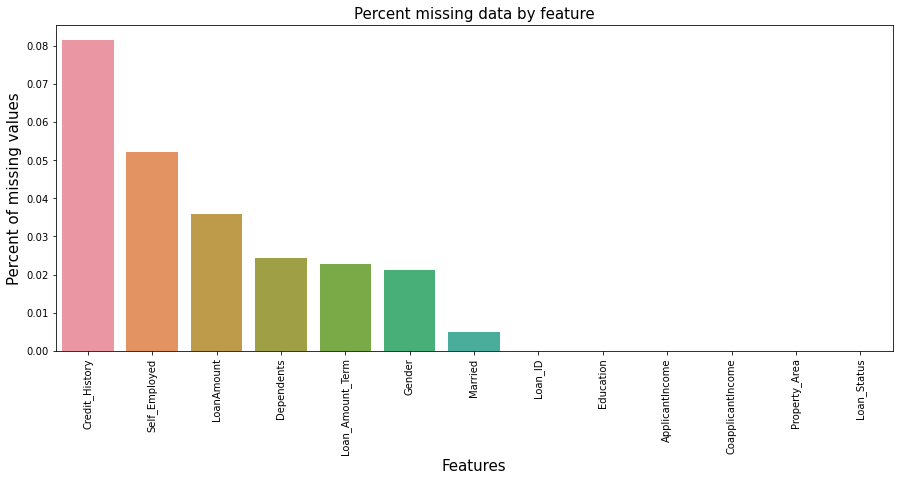

In [9]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head(7)

In [10]:
# Replace class
df=df.replace({'Loan_Status': {'Y':1, 'N':0}})
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1


In [11]:
df.Credit_History.fillna(df.Credit_History.mean(),inplace=True)
df.Self_Employed.fillna(df.Self_Employed.mode()[0],inplace=True)
df.LoanAmount.fillna(df.LoanAmount.mean(),inplace=True)
df.Dependents.fillna(df.Dependents.mode()[0],inplace=True)
df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.mean(),inplace=True)
df.Gender.fillna(df.Gender.mode()[0],inplace=True)
df.Married.fillna(df.Married.mode()[0],inplace=True)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = (train_test_split(df.iloc[:,6:10], df.iloc[:,12], test_size=0.3))
print ("Training size: %d" %len(y_train))
print ("Test size : %d" %len(y_test))

Training size: 429
Test size : 185


## Training KNN with K=3

In [22]:
clf = neighbors.KNeighborsClassifier(n_neighbors = 3, p = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print ("Print results for first 20 test data points:")
print ("Predicted labels: ", y_pred[0:20].tolist())
print ("Ground truth : ", y_test[0:20].tolist())

Print results for first 20 test data points:
Predicted labels:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Ground truth :  [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [14]:
from sklearn.metrics import accuracy_score
print ("Accuracy of 1NN: %.2f %%" %(100*accuracy_score(y_test, y_pred)))

Accuracy of 1NN: 62.16 %


## Training KNN with K=7

In [15]:
clf = neighbors.KNeighborsClassifier(n_neighbors = 7, p = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print ("Print results for first 20 test data points:")
print ("Predicted labels: ", y_pred[0:20].tolist())
print ("Ground truth : ", y_test[0:20].tolist())

Print results for first 20 test data points:
Predicted labels:  [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ground truth :  [1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]


In [16]:
from sklearn.metrics import accuracy_score
print ("Accuracy of 1NN: %.2f %%" %(100*accuracy_score(y_test, y_pred)))

Accuracy of 1NN: 65.41 %
